# Try 2

## Install Dependencies


In [ ]:
!pip install PySastrawi
!pip install swifter

     |████████████████████████████████| 215kB 31.5MB/s 
     |████████████████████████████████| 634kB 27.4MB/s 
     |████████████████████████████████| 296kB 42.2MB/s 
     |████████████████████████████████| 583kB 41.7MB/s 
     |████████████████████████████████| 112kB 57.1MB/s 
     |████████████████████████████████| 48.5MB 62kB/s 
     |████████████████████████████████| 17.2MB 191kB/s 
     |████████████████████████████████| 204kB 56.0MB/s 
     |████████████████████████████████| 81kB 11.9MB/s 
     |████████████████████████████████| 3.1MB 42.1MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
     |████████████████████████████████| 1.3MB 34.1MB/s 
     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 133kB 53.0MB/s 
     |████████████████████████████████| 92kB 11.4MB/s 
     |████████████████████████████████| 143kB 55.6MB/s 
     |████████████████████████████████| 296kB 56.2MB/s 
  Created wheel for swifter: filename=swifter-1.0.7-cp3

In [ ]:
import csv
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import re
import os
import string
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Text Pre-Processing

In [ ]:
df_dataset = pd.read_csv('/content/drive/MyDrive/data/train_indo.csv')

In [ ]:
df_dataset.head(5)

,deskripsi,komentar,menatap,memegang
0,"Sedang berjalan di sepanjang jalan yang ramai,...",0,0,1
1,"Kejadian ini terjadi pada malam hari, saya ber...",0,1,0
2,SAYA MENUNGGU BUS. SEORANG PRIA DATANG DENGAN ...,1,0,0
3,Insiden terjadi di dalam kereta,0,0,0
4,Saya menyaksikan sebuah insiden ketika sebuah ...,0,0,0


In [ ]:
# remove special char
def remove_special_char(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")

# remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

# remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

# remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

# remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

# remove single char
def remove_single_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

# NLTK word rokenize 
def word_tokenize_wrapper(text):
    return word_tokenize(text)


In [ ]:
df_dataset['deskripsi'] = df_dataset['deskripsi'].str.lower()
df_dataset['deskripsi'] = df_dataset['deskripsi'].apply(remove_special_char)
df_dataset['deskripsi'] = df_dataset['deskripsi'].apply(remove_number)
df_dataset['deskripsi'] = df_dataset['deskripsi'].apply(remove_punctuation)
df_dataset['deskripsi'] = df_dataset['deskripsi'].apply(remove_whitespace_LT)
df_dataset['deskripsi'] = df_dataset['deskripsi'].apply(remove_whitespace_multiple)
df_dataset['deskripsi'] = df_dataset['deskripsi'].apply(remove_single_char)
df_dataset['deskripsi'] = df_dataset['deskripsi'].apply(word_tokenize_wrapper)

In [ ]:
# stopwords_removal
list_stopwords = stopwords.words('indonesian')
txt_stopword = pd.read_csv("/content/drive/MyDrive/data/stopwords-id.txt", names= ["stopwords"], header = None)
list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))
list_stopwords = set(list_stopwords)

def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

df_dataset['deskripsi'] = df_dataset['deskripsi'].apply(stopwords_removal) 

In [ ]:
# Normalizing
normalizad_word = pd.read_csv("/content/drive/MyDrive/data/normalisasi.csv")

normalizad_word_dict = {}

for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

df_dataset['deskripsi'] = df_dataset['deskripsi'].apply(normalized_term)


In [ ]:
# Stemming
# Create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df_dataset['deskripsi']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    
# Apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df_dataset['deskripsi'] = df_dataset['deskripsi'].swifter.apply(get_stemmed_term)

In [ ]:
# Detokenize
def untokenize(words):
    text = ' '.join(words)
    text = text.replace("`` ", '"').replace(" ''", '"').replace('. . .',  '...')
    text = text.replace(" ( ", " (").replace(" ) ", ") ")
    text = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", text)
    text = re.sub(r' ([.,:;?!%]+)$', r"\1", text)
    return text.strip()

df_dataset['deskripsi'] = df_dataset['deskripsi'].apply(untokenize)

## Create Dataset and Pipeline for Model

In [ ]:
df_dataset

,deskripsi,komentar,menatap,memegang
0,jalan jalan ramai pegang tangan lelaki tua mer...,0,0,1
1,jadi malam metro orang tatap,0,1,0
2,tunggu bus pria sepeda tawar gadis muda liftvto,1,0,0
3,insiden kereta,0,0,0
4,saksi insiden rantai renggut brutal wanita tua...,0,0,0
...,...,...,...,...
8897,komentar tatap senonoh,1,0,0
8898,pergi teman metro pagi kelompok anak lakilaki ...,1,0,1
8899,coba tangkap jalan stasiun kereta api stasiun ...,0,0,1
8900,orang jahat sentuh pribadi ranchibhagalpur exp...,0,0,1


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_dataset, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

5696 train examples
1425 validation examples
1781 test examples


In [ ]:
train_deskripsi = train['deskripsi']
train_label_komentar = train['komentar']
train_label_menatap = train['menatap']
train_label_memegang = train['memegang']

val_deskripsi = val['deskripsi']
val_label_komentar = val['komentar']
val_label_menatap = val['menatap']
val_label_memegang = val['memegang']

test_deskripsi = test['deskripsi']
test_label_komentar = test['komentar']
test_label_menatap = test['menatap']
test_label_memegang = test['memegang']

In [ ]:
def df_to_datasetBatch(dataframe, dataframe_label, batch_size, prefetch, shuffle):
  dataframe = dataframe.values
  labels = dataframe_label.values.astype(dtype=np.float32)
  ds = tf.data.Dataset.from_tensor_slices((dataframe, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(prefetch)
  return ds

In [ ]:
batch_size = 20
prefetch = 1
shuffle = True

#Komentar
train_komentar_batches = df_to_datasetBatch(train_deskripsi, train_label_komentar, batch_size=batch_size, prefetch=prefetch, shuffle=shuffle)
val_komentar_batches = df_to_datasetBatch(val_deskripsi, val_label_komentar, batch_size=batch_size, prefetch=prefetch, shuffle=shuffle)
test_komentar_batches = df_to_datasetBatch(test_deskripsi, test_label_komentar, batch_size=batch_size, prefetch=prefetch, shuffle=shuffle)

#Menatap
train_menatap_batches = df_to_datasetBatch(train_deskripsi, train_label_menatap, batch_size=batch_size, prefetch=prefetch, shuffle=shuffle)
val_menatap_batches = df_to_datasetBatch(val_deskripsi, val_label_menatap, batch_size=batch_size, prefetch=prefetch, shuffle=shuffle)
test_menatap_batches = df_to_datasetBatch(test_deskripsi, test_label_menatap, batch_size=batch_size, prefetch=prefetch, shuffle=shuffle)

#Memegang
train_memegang_batches = df_to_datasetBatch(train_deskripsi, train_label_memegang, batch_size=batch_size, prefetch=prefetch, shuffle=shuffle)
val_memegang_batches = df_to_datasetBatch(val_deskripsi, val_label_memegang, batch_size=batch_size, prefetch=prefetch, shuffle=shuffle)
test_memegang_batches = df_to_datasetBatch(test_deskripsi, test_label_memegang, batch_size=batch_size, prefetch=prefetch, shuffle=shuffle)

In [ ]:
train_komentar_batches

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.float32)>

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-id-dim128/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

## Create Komentar Model

In [ ]:
modelKomentar = tf.keras.Sequential([
        hub_layer,
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')])


modelKomentar.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

modelKomentar.summary()

historyKomentar = modelKomentar.fit(train_komentar_batches,
                        validation_data=val_komentar_batches,
                        epochs=10)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 128)               112461824 
_________________________________________________________________
dense_59 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_31 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 17        
Total params: 112,463,905
Trainable params: 112,463,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
285/285 [==============================] - 18s 61ms/step - loss: 0.5740 - accuracy: 0.7546 - val_loss: 0.5435 - val_accuracy: 0.7656
Epoch 2/15
285/285 [==============================] - 17s 60ms/step - loss: 0.3835 - accuracy

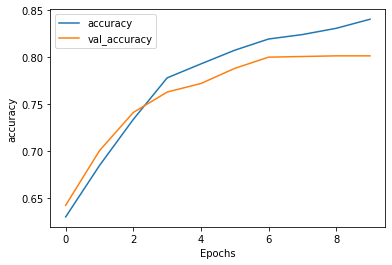

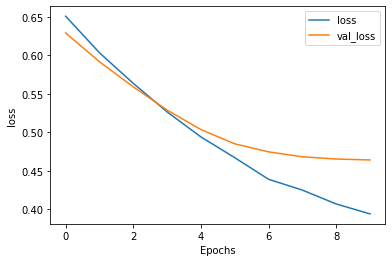

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(historyKomentar, "accuracy")
plot_graphs(historyKomentar, "loss")

In [ ]:
eval_results_komentar = modelKomentar.evaluate(test_komentar_batches, verbose=0)

for metric, value in zip(modelKomentar.metrics_names, eval_results_komentar):
    print(metric + ': {:.3}'.format(value))

loss: 0.468
accuracy: 0.797


## Create Menatap Model

In [ ]:
train_menatap_batches

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.float32)>

In [ ]:
modelTatap = tf.keras.Sequential([
        hub_layer,
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')])


modelTatap.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

modelTatap.summary()

historyTatap = modelTatap.fit(train_menatap_batches,
                        validation_data=val_menatap_batches,
                        epochs=10)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               112461824 
_________________________________________________________________
dense_4 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 112,463,905
Trainable params: 112,463,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
285/285 [==============================] - 18s 62ms/step - loss: 0.6327 - accuracy: 0.7231 - val_loss: 0.5796 - val_accuracy: 0.7712
Epoch 2/10
285/285 [==============================] - 17s 61ms/step - loss: 0.5382 - accuracy:

In [ ]:
eval_results_menatap = modelTatap.evaluate(test_menatap_batches, verbose=0)

for metric, value in zip(modelTatap.metrics_names, eval_results_menatap):
    print(metric + ': {:.3}'.format(value))

loss: 0.431
accuracy: 0.831


## Create Memegang Model

In [ ]:
train_memegang_batches

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.float32)>

In [ ]:
modelPegang = tf.keras.Sequential([
        hub_layer,
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')])


modelPegang.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

modelPegang.summary()

historyPegang = modelPegang.fit(train_memegang_batches,
                        validation_data=val_memegang_batches,
                        epochs=10)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               112461824 
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 112,463,905
Trainable params: 112,463,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
285/285 [==============================] - 18s 62ms/step - loss: 0.6327 - accuracy: 0.6773 - val_loss: 0.5904 - val_accuracy: 0.7088
Epoch 2/10
285/285 [==============================] - 18s 62ms/step - loss: 0.5552 - accuracy:

In [ ]:
eval_results_memegang = modelPegang.evaluate(test_memegang_batches, verbose=0)

for metric, value in zip(modelPegang.metrics_names, eval_results_memegang):
    print(metric + ': {:.3}'.format(value))

loss: 0.368
accuracy: 0.862


## Save Model

In [ ]:
modelKomentar.save('/content/model')

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/model/') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('modelKomentar.tflite', 'wb') as f:
  f.write(tflite_model)


ConverterError: ignored